# MIDAS downstream analysis

In [24]:
source("/root/workspace/code/sc-transformer/preprocess/utils.R")
setwd("/root/workspace/code/sc-transformer/")
library(mclust)
library(RColorBrewer)

parser <- ArgumentParser()
parser$add_argument("--task", type = "character", default = "dogma_full")
parser$add_argument("--method", type = "character", default = "midas_embed")
parser$add_argument("--exp", type = "character", default = "e0")
o <- parser$parse_known_args()[[1]]

config <- parseTOML("configs/data.toml")[[o$task]]
subset_names <- basename(config$raw_data_dirs)
subset_ids <- sapply(seq_along(subset_names) - 1, toString)
input_dirs <- pj("result", o$task, o$exp, "default", "predict", "sp_latest", paste0("subset_", subset_ids))
pp_dir <- pj("data", "processed", o$task)
output_dir <- pj("result", "analysis", o$task, o$method)
mkdir(output_dir, remove_old = F)
label_paths <- pj(config$raw_data_dirs, "label_seurat", "l2.csv")

K <- parseTOML("configs/model.toml")[["default"]]$dim_c
qual_col_pals <- brewer.pal.info[brewer.pal.info$category == 'qual',]
dcols <- unlist(mapply(brewer.pal, qual_col_pals$maxcolors, rownames(qual_col_pals)))
l <- 5  # figure size
L <- 8   # figure size
m <- 0.5  # legend margin

## Load model outputs

In [25]:
z_list <- list()
rna_bc_list <- list()
atac_bc_list <- list()
adt_bc_list <- list()
cell_name_list <- list()
label_list <- list()
subset_name_list <- list()
S <- length(subset_names)
for (i in seq_along(subset_names)) {
    subset_name <- subset_names[i]
    z_dir       <- pj(input_dirs[i], "z", "joint")
    rna_bc_dir  <- pj(input_dirs[i], "x_bc", "rna")
    atac_bc_dir <- pj(input_dirs[i], "x_bc", "atac")
    adt_bc_dir  <- pj(input_dirs[i], "x_bc", "adt")
    fnames <- dir(path = z_dir, pattern = ".csv$")
    fnames <- str_sort(fnames, decreasing = F)

    z_subset_list <- list()
    rna_bc_subset_list <- list()
    atac_bc_subset_list <- list()
    adt_bc_subset_list <- list()
    N <- length(fnames)
    for (n in seq_along(fnames)) {
        message(paste0("Loading Subset ", i, "/", S, ", File ", n, "/", N))
        z_subset_list[[n]] <- read.csv(file.path(z_dir, fnames[n]), header = F)
        rna_bc_subset_list[[n]] <- read.csv(file.path(rna_bc_dir, fnames[n]), header = F)
        atac_bc_subset_list[[n]] <- read.csv(file.path(atac_bc_dir, fnames[n]), header = F)
        adt_bc_subset_list[[n]] <- read.csv(file.path(adt_bc_dir, fnames[n]), header = F)
    }
    z_list[[subset_name]] <- bind_rows(z_subset_list)
    rna_bc_list[[subset_name]] <- bind_rows(rna_bc_subset_list)
    atac_bc_list[[subset_name]] <- bind_rows(atac_bc_subset_list)
    adt_bc_list[[subset_name]] <- bind_rows(adt_bc_subset_list)

    cell_name_list[[subset_name]] <- read.csv(pj(pp_dir, paste0("subset_", subset_ids[i]),
        "cell_names.csv"), header = T)[, 2]
    label_list[[subset_name]] <- read.csv(label_paths[i], header = T)[, 2]
    subset_name_list[[subset_name]] <- rep(subset_name, length(cell_name_list[[subset_name]]))
}

Loading Subset 1/4, File 1/29

Loading Subset 1/4, File 2/29

Loading Subset 1/4, File 3/29

Loading Subset 1/4, File 4/29

Loading Subset 1/4, File 5/29

Loading Subset 1/4, File 6/29

Loading Subset 1/4, File 7/29

Loading Subset 1/4, File 8/29

Loading Subset 1/4, File 9/29

Loading Subset 1/4, File 10/29

Loading Subset 1/4, File 11/29

Loading Subset 1/4, File 12/29

Loading Subset 1/4, File 13/29

Loading Subset 1/4, File 14/29

Loading Subset 1/4, File 15/29

Loading Subset 1/4, File 16/29

Loading Subset 1/4, File 17/29

Loading Subset 1/4, File 18/29

Loading Subset 1/4, File 19/29

Loading Subset 1/4, File 20/29

Loading Subset 1/4, File 21/29

Loading Subset 1/4, File 22/29

Loading Subset 1/4, File 23/29

Loading Subset 1/4, File 24/29

Loading Subset 1/4, File 25/29

Loading Subset 1/4, File 26/29

Loading Subset 1/4, File 27/29

Loading Subset 1/4, File 28/29

Loading Subset 1/4, File 29/29

Loading Subset 2/4, File 1/24

Loading Subset 2/4, File 2/24

Loading Subset 2/4,

## Create seurat object

In [26]:
rna_bc <- t(data.matrix(bind_rows(rna_bc_list)))
colnames(rna_bc) <- do.call("c", unname(cell_name_list))
rownames(rna_bc) <- read.csv(pj(pp_dir, "feat", "feat_names_rna.csv"), header = T)[, 2]
obj <- CreateSeuratObject(counts = rna_bc, assay = "rna_bc")

adt_bc <- t(data.matrix(bind_rows(adt_bc_list)))
colnames(adt_bc) <- colnames(obj)
rownames(adt_bc) <- read.csv(pj(pp_dir, "feat", "feat_names_adt.csv"), header = T)[, 2]
obj[["adt_bc"]] <- CreateAssayObject(counts = adt_bc)

atac_bc <- t(data.matrix(bind_rows(atac_bc_list)))
# h <- nrow(atac_bc)
# w <- ncol(atac_bc)
# atac_bc[] <- rbinom(n = h * w, size = 1, prob = atac_bc)
# atac_bc <- (atac_bc > pmax(matrix(rowMeans(atac_bc), h, w, byrow = F),
#                            matrix(colMeans(atac_bc), h, w, byrow = T))) * 1
colnames(atac_bc) <- colnames(obj)
rownames(atac_bc) <- read.csv(pj(pp_dir, "feat", "feat_names_atac.csv"), header = T)[, 2]
annotation <- GetGRangesFromEnsDb(EnsDb.Hsapiens.v86)
seqlevelsStyle(annotation) <- "UCSC"
genome(annotation) <- "hg38"
obj[["atac_bc"]] <- CreateChromatinAssay(counts = atac_bc, genome = 'hg38', annotation = annotation)

z <- data.matrix(bind_rows(z_list))
c <- z[, 1:K]
colnames(c) <- paste0("c_", seq_len(ncol(c)))
rownames(c) <- colnames(obj)
obj[["c"]] <- CreateDimReducObject(embeddings = c, key = "c_", assay = "rna_bc")

obj@meta.data$l2 <- do.call("c", unname(label_list))
obj@meta.data$batch <- do.call("c", unname(subset_name_list))
table(obj@meta.data$batch)[unique(obj@meta.data$batch)]

obj
obj <- subset(obj, subset = nCount_atac_bc > 0 & nCount_rna_bc > 0 & nCount_adt_bc > 0)
obj

Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from adt_bc_ to adtbc_"
Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregat


lll_ctrl lll_stim dig_ctrl dig_stim 
    7361     5897    10190     9527 

An object of class Seurat 
34842 features across 32975 samples within 3 assays 
Active assay: rna_bc (4045 features, 0 variable features)
 2 other assays present: adt_bc, atac_bc
 1 dimensional reduction calculated: c

An object of class Seurat 
34842 features across 32975 samples within 3 assays 
Active assay: rna_bc (4045 features, 0 variable features)
 2 other assays present: adt_bc, atac_bc
 1 dimensional reduction calculated: c

## Preprocess data

In [27]:
DefaultAssay(obj) <- "atac_bc"
obj <-  RunTFIDF(obj) %>%
        FindTopFeatures(min.cutoff = "q25")

DefaultAssay(obj) <- "rna_bc"
VariableFeatures(obj) <- rownames(obj)
obj <-  NormalizeData(obj) %>%
        # FindVariableFeatures(nfeatures = 2000) %>%
        ScaleData()

DefaultAssay(obj) <- "adt_bc"
VariableFeatures(obj) <- rownames(obj)
obj <-  NormalizeData(obj, normalization.method = "CLR", margin = 2) %>%
        ScaleData()

Performing TF-IDF normalization

Warning message in mccollect(jobs = jobs, wait = TRUE):
"1 parallel job did not deliver a result"
Warning message in mccollect(jobs = jobs, wait = TRUE):
"1 parallel job did not deliver a result"
Warning message in mccollect(jobs = jobs, wait = TRUE):
"1 parallel job did not deliver a result"
Warning message in mccollect(jobs = jobs, wait = TRUE):
"1 parallel job did not deliver a result"
Warning message in mccollect(jobs = jobs, wait = TRUE):
"1 parallel job did not deliver a result"
Warning message in mccollect(jobs = jobs, wait = TRUE):
"1 parallel job did not deliver a result"
Warning message in mccollect(jobs = jobs, wait = TRUE):
"1 parallel job did not deliver a result"
Warning message in mccollect(jobs = jobs, wait = TRUE):
"1 parallel job did not deliver a result"
Warning message in mccollect(jobs = jobs, wait = TRUE):
"1 parallel job did not deliver a result"
Warning message in mccollect(jobs = jobs, wait = TRUE):
"1 parallel job did not deliv

## Visualize dimensionality reduction results

In [28]:
obj <- RunUMAP(obj, reduction = 'c', dims = 1:K, reduction.name = 'midas.umap',
    reduction.key = 'midasUMAP_')

17:24:00 UMAP embedding parameters a = 0.9922 b = 1.112

17:24:00 Read 32975 rows and found 32 numeric columns

17:24:00 Using Annoy for neighbor search, n_neighbors = 30

17:24:00 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

17:24:05 Writing NN index file to temp file /tmp/RtmpOZtjRC/fileca072eb70ed7

17:24:05 Searching Annoy index using 64 threads, search_k = 3000

17:24:05 Annoy recall = 100%

17:24:08 Commencing smooth kNN distance calibration using 64 threads

17:24:12 Initializing from normalized Laplacian + noise

17:24:14 Commencing optimization for 200 epochs, with 1446624 positive edges

17:24:30 Optimization finished



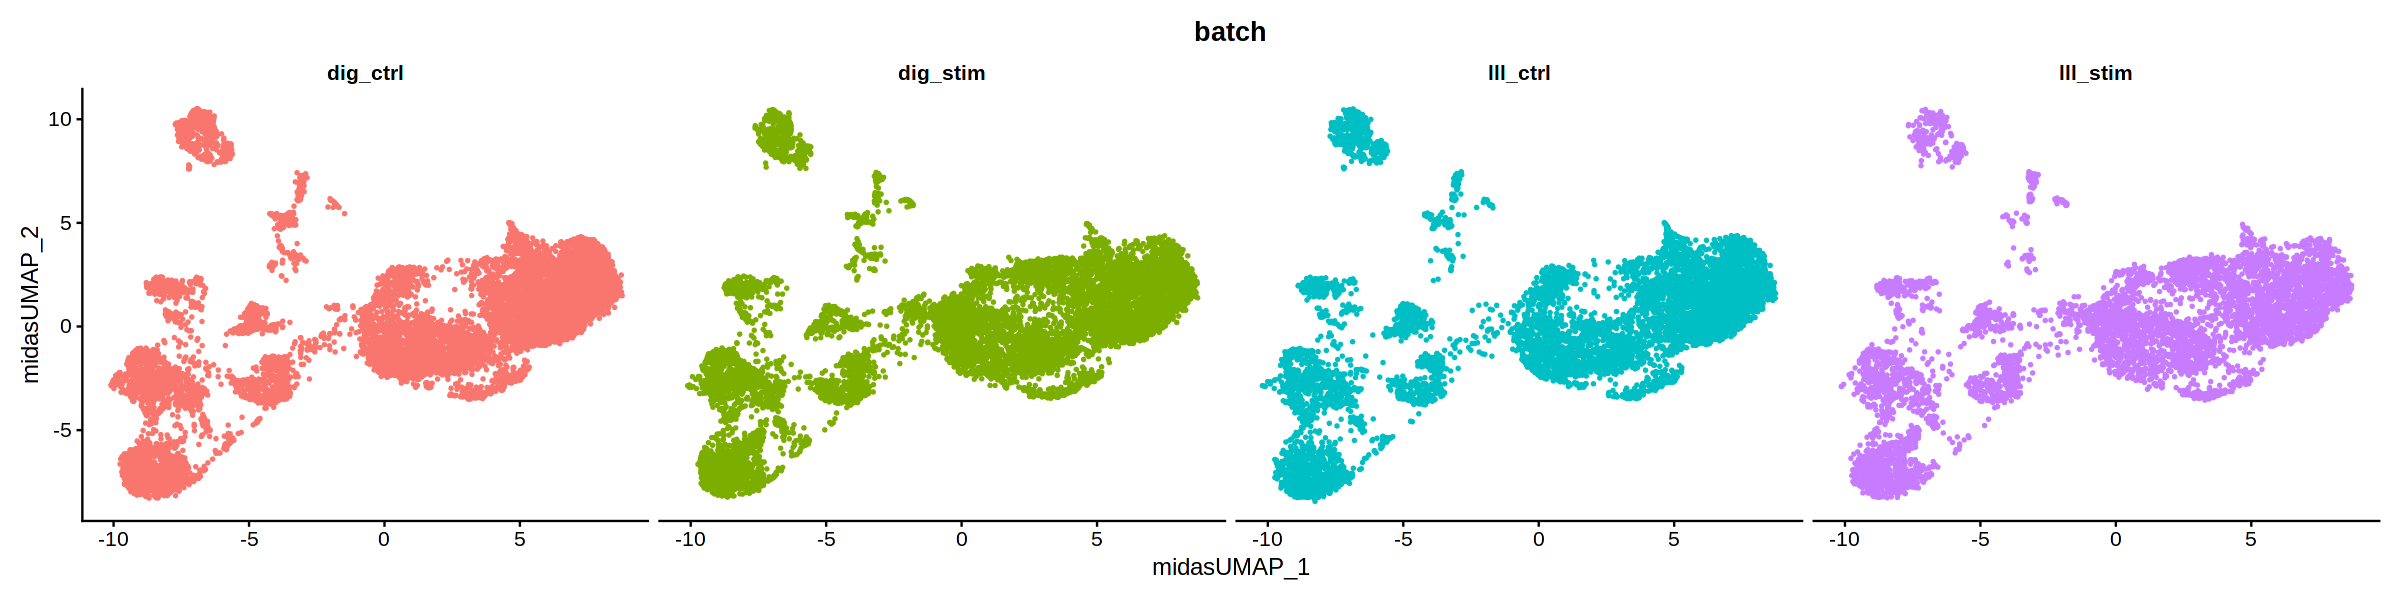

In [29]:
plt_size(w = 4*l, h = l)
DimPlot(obj, reduction = 'midas.umap', split.by = "batch", group.by = "batch", label = F,
    repel = T, label.size = 4, pt.size = 0.5) + NoLegend()
ggsave(file = pj(output_dir, paste0(o$method, "_split.png")), width = 4*l, height = l)

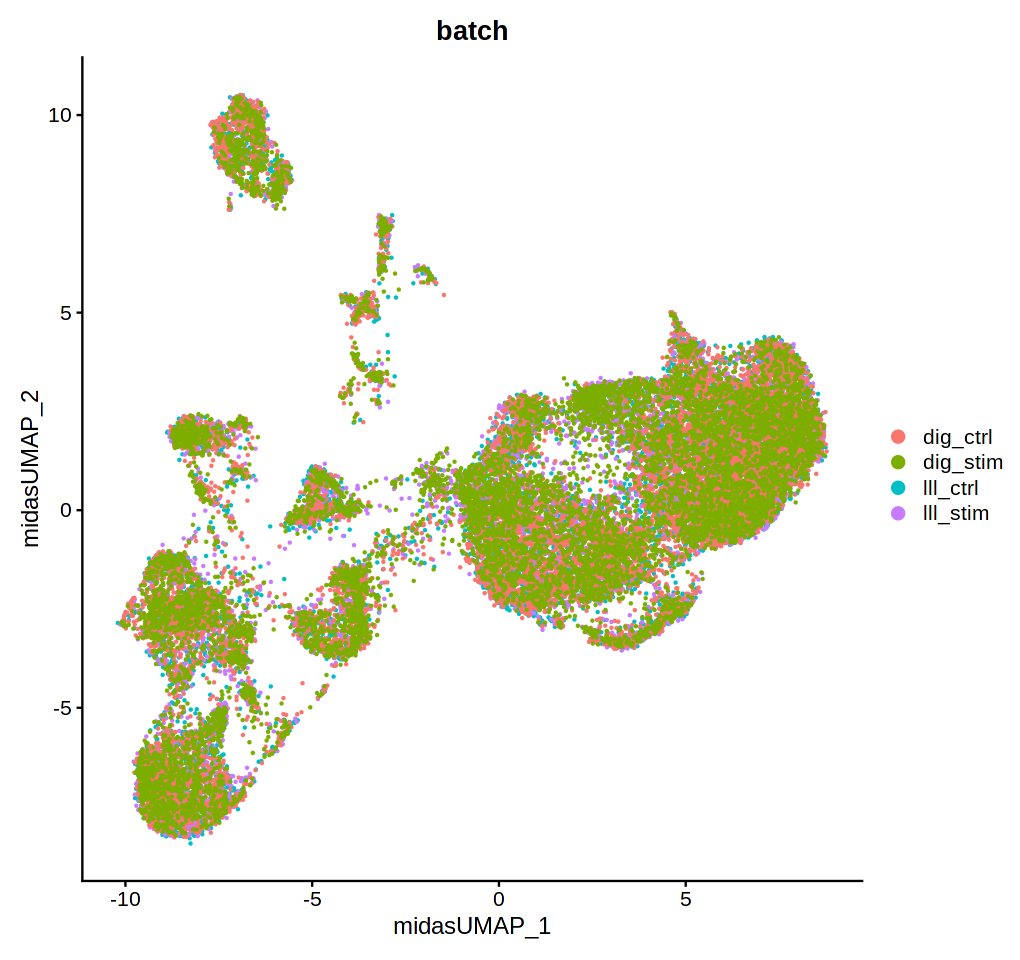

In [30]:
plt_size(w = L+m, h = L)
DimPlot(obj, reduction = 'midas.umap', group.by = "batch", label = F, repel = T,
    label.size = 4, pt.size = 0.2)
ggsave(file = pj(output_dir, paste0(o$method, "_merged.png")), width = L+m, height = L)

## Clustering

In [31]:
obj <- FindNeighbors(obj, reduction = 'c', dims = 1:K, assay = "rna_bc")
obj <- FindClusters(obj, graph.name = "rna_bc_snn", algorithm = 3, resolution = 0.35)
table(obj@meta.data$seurat_clusters)
ari <- adjustedRandIndex(obj@meta.data$seurat_clusters, obj@meta.data$l2)
prt("ARI: ", ari)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 32975
Number of edges: 1084376

Running smart local moving algorithm...
Maximum modularity in 10 random starts: 0.9308
Number of communities: 15
Elapsed time: 46 seconds


Warning message:
"UNRELIABLE VALUE: One of the 'future.apply' iterations ('future_lapply-1') unexpectedly generated random numbers without declaring so. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'future.seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'future.seed = NULL', or set option 'future.rng.onMisuse' to "ignore"."



    0     1     2     3     4     5     6     7     8     9    10    11    12 
10303  6276  3190  2821  1582  1510  1486  1124  1079   994   782   675   460 
   13    14 
  382   311 

ARI: 0.470863807428719


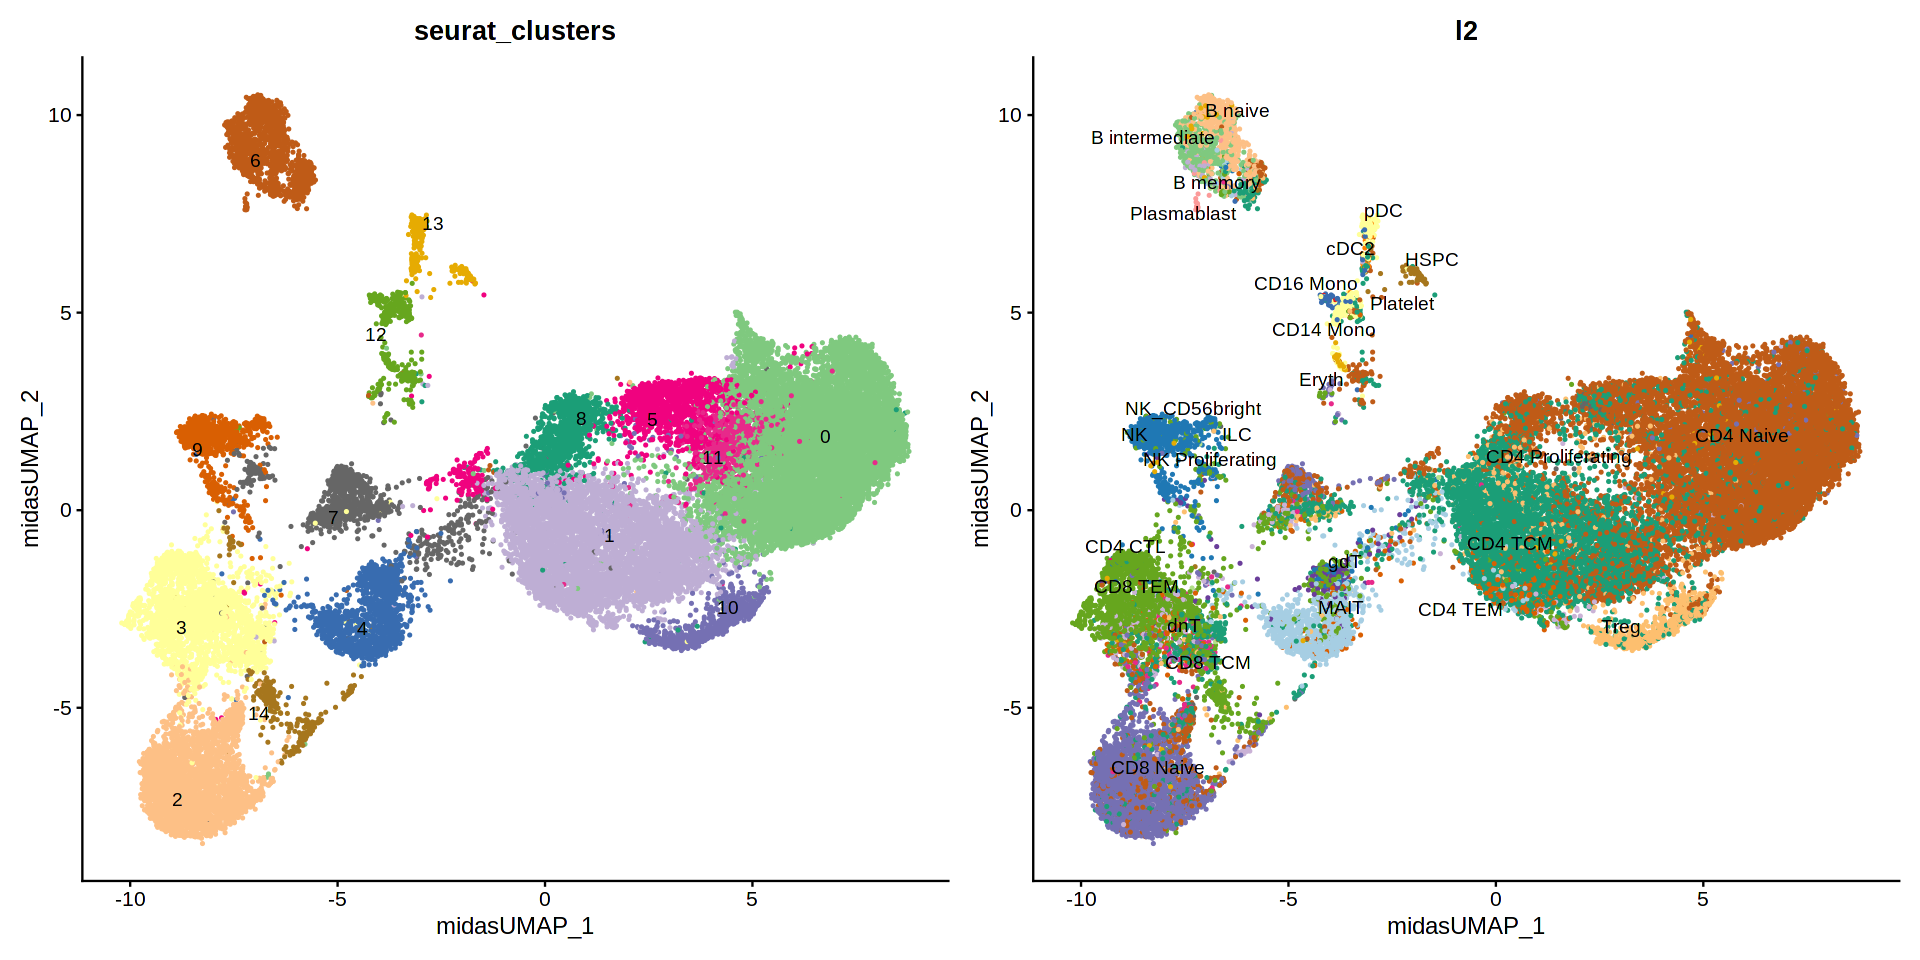

In [32]:
plt_size(w = 2*L, h = L)
p1 <- DimPlot(obj, reduction = 'midas.umap', group.by = "seurat_clusters", label = T, repel = T,
    label.size = 4, pt.size = 0.4, cols = dcols) + NoLegend()
p2 <- DimPlot(obj, reduction = 'midas.umap', group.by = "l2", label = T, repel = T,
    label.size = 4, pt.size = 0.4, cols = dcols) + NoLegend()
p1 + p2
ggsave(file = pj(output_dir, "midas_clusters_l2.png"), width = 2*L, height = L)

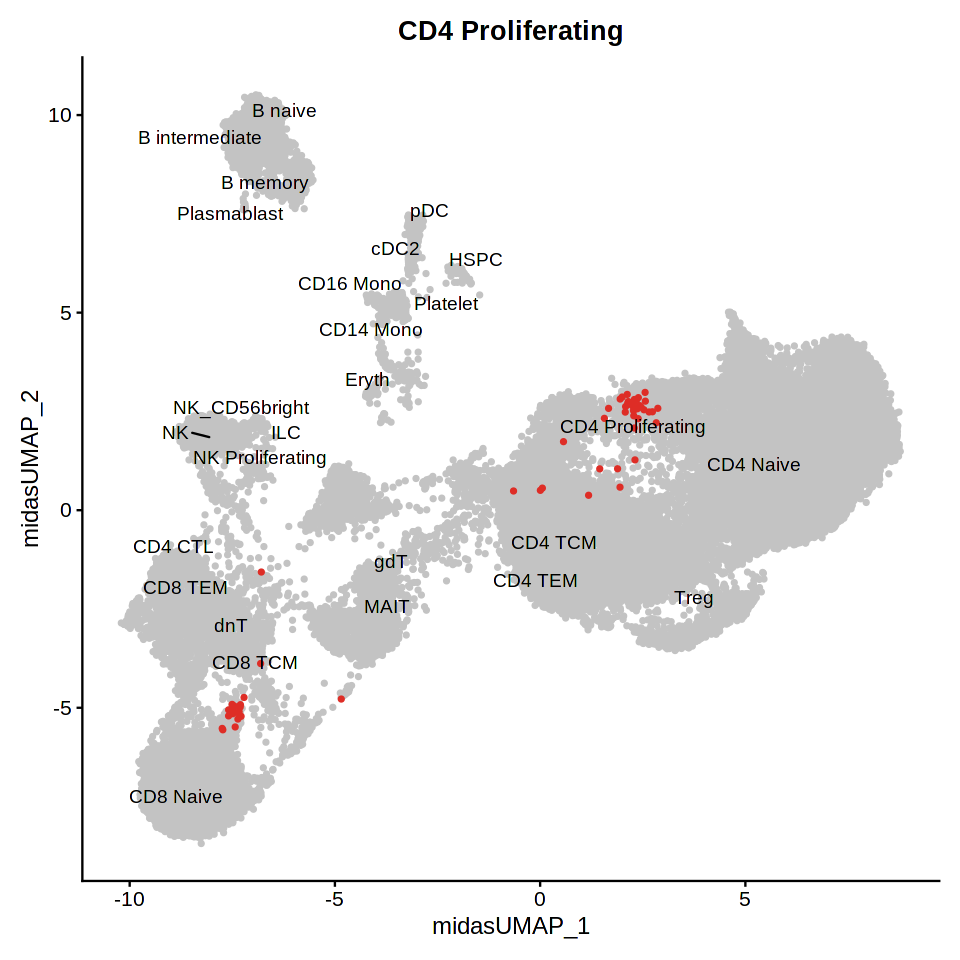

In [33]:
# highlight individual cell types
plt_size(w = L, h = L)
label <- "CD4 Proliferating"
hl <- colnames(obj)[obj@meta.data$l2 == label]
DimPlot(obj, reduction = 'midas.umap', group.by = "l2", label = T, repel = T, label.size = 4,
    pt.size = 1, cells.highlight = hl) + ggtitle(label) + NoLegend()
ggsave(file = pj(output_dir, paste0("highlight_", label, ".png")), width = L, height = L)

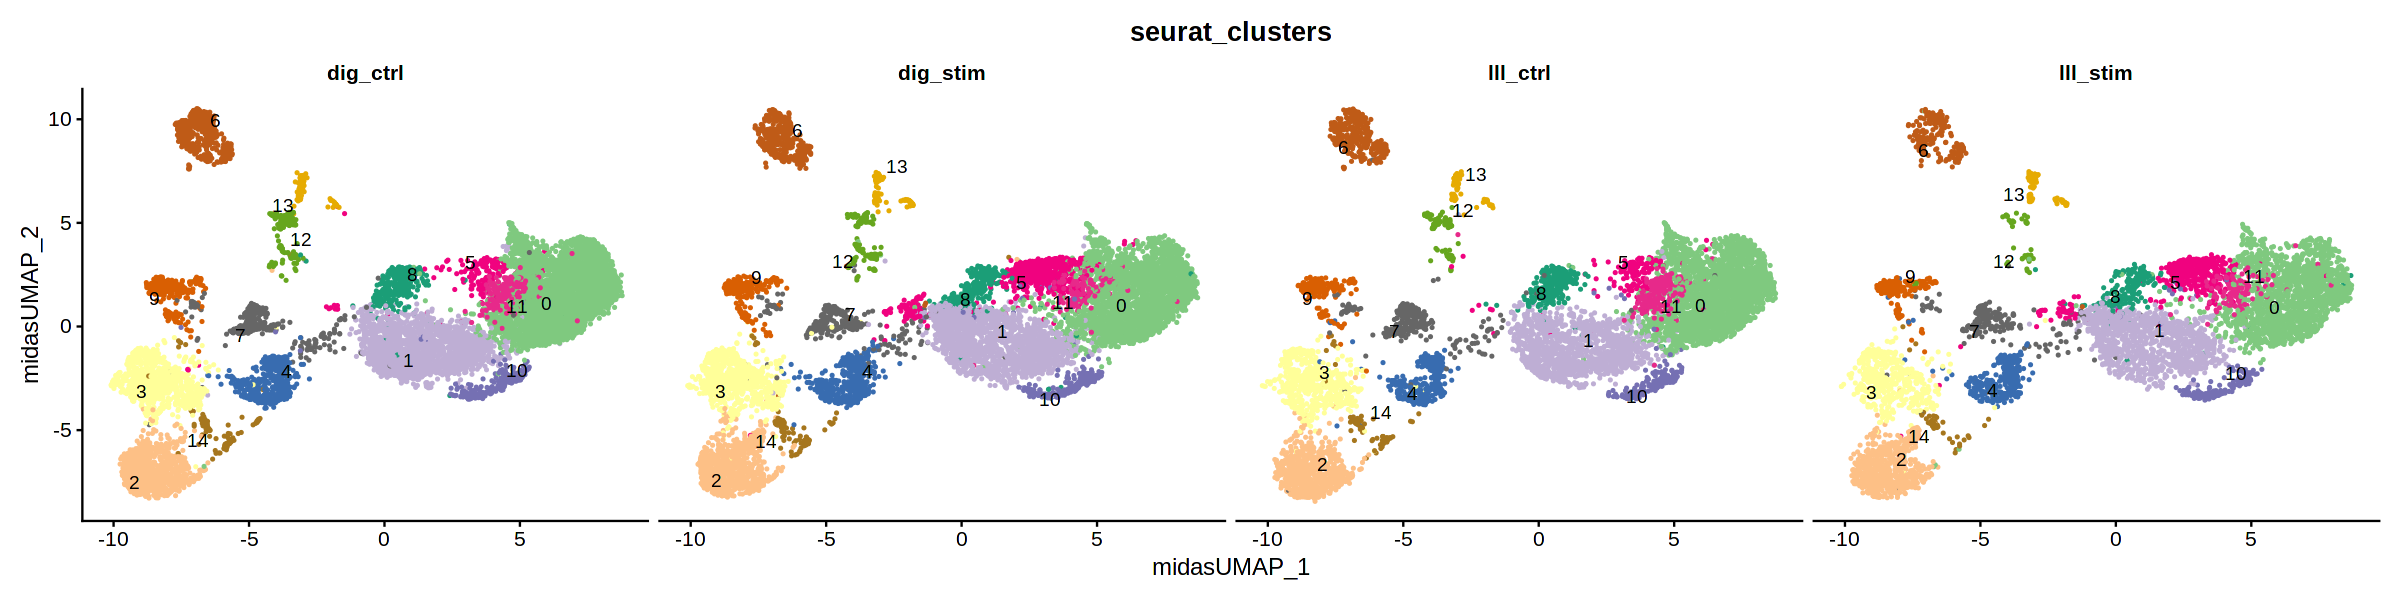

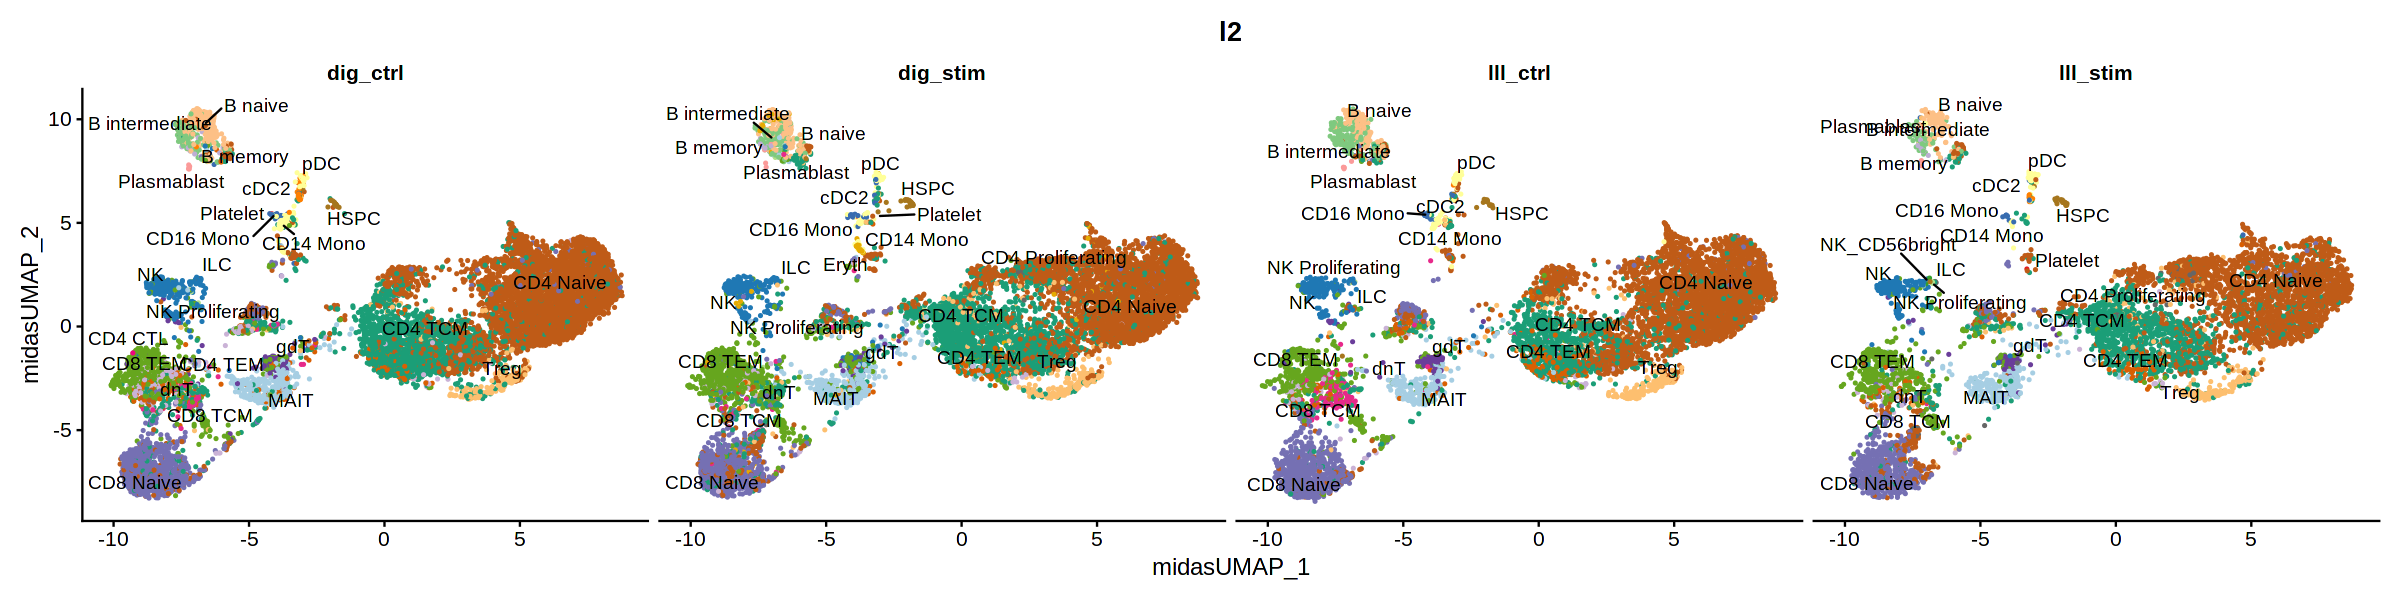

In [34]:
plt_size(w = 4*l, h = l)
DimPlot(obj, reduction = 'midas.umap', split.by = "batch", group.by = "seurat_clusters", label = T,
    repel = T, label.size = 4, pt.size = 0.4, cols = dcols) + NoLegend()
ggsave(file = pj(output_dir, "midas_clusters_split.png"), width = 4*l, height = l)

DimPlot(obj, reduction = 'midas.umap', split.by = "batch", group.by = "l2", label = T,
    repel = T, label.size = 4, pt.size = 0.4, cols = dcols) + NoLegend()
ggsave(file = pj(output_dir, "midas_l2_split.png"), width = 4*l, height = l)

## Differential expression analysis

### RNA DE

In [35]:
DefaultAssay(obj) <- "rna_bc"
markers_rna <- FindAllMarkers(obj, only.pos = T, min.pct = 0.25, logfc.threshold = 0.25)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14



In [36]:
markers_rna %>% group_by(cluster) %>%  slice_max(n = 3, order_by = avg_log2FC)

p_val         avg_log2FC pct.1 pct.2 p_val_adj     cluster gene      
1   0.000000e+00 1.8158581  0.916 0.547  0.000000e+00 0       FHIT      
2   0.000000e+00 1.6293794  0.803 0.458  0.000000e+00 0       PLCL1     
3   0.000000e+00 1.6279993  0.783 0.423  0.000000e+00 0       TSHZ2     
4   0.000000e+00 2.1149436  0.744 0.223  0.000000e+00 1       ADAM19    
5   0.000000e+00 1.5519442  0.580 0.211  0.000000e+00 1       ITGB1     
6   0.000000e+00 1.4756128  0.428 0.119  0.000000e+00 1       MAF       
7   0.000000e+00 2.1088633  0.915 0.453  0.000000e+00 2       NELL2     
8   0.000000e+00 1.9406081  0.620 0.151  0.000000e+00 2       LRRN3     
9   0.000000e+00 1.8622414  0.402 0.060  0.000000e+00 2       CD8B      
10  0.000000e+00 2.1873384  0.511 0.119  0.000000e+00 3       ZEB2      
11  0.000000e+00 2.0844699  0.542 0.098  0.000000e+00 3       CD8A      
12  0.000000e+00 2.0467264  0.339 0.051  0.000000e+00 3       C1orf21   
13  0.000000e+00 3.4650776  0.619 0.032  0.000000e+00 4       SLC4A10   
14  0.000000e+00 2.7672767  0.633 0.055  0.000000e+00 4       ZBTB16    
15  0.000000e+00 2.6101926  0.871 0.228  0.000000e+00 4       PLCB1     
16 1.882581e-136 1.5292760  0.452 0.206 7.615041e-133 5       LTA       
17  7.139855e-95 0.9192989  0.495 0.270  2.888072e-91 5       MTHFD1L   
18  7.939743e-97 0.8982568  0.577 0.341  3.211626e-93 5       KCNQ5     
19  0.000000e+00 4.4181702  0.889 0.014  0.000000e+00 6       EBF1      
20  0.000000e+00 4.3430984  0.950 0.142  0.000000e+00 6       IGKC      
21  0.000000e+00 4.2144666  0.853 0.020  0.000000e+00 6       IGHM      
22 7.069998e-136 0.7552530  0.277 0.069 2.859814e-132 7       C1orf21   
23 7.331423e-150 0.7162333  0.747 0.321 2.965561e-146 7       AOAH      
24 2.184210e-137 0.7137202  0.678 0.281 8.835131e-134 7       MYBL1     
25 1.912443e-153 0.7822863  0.945 0.522 7.735833e-150 8       TSHZ2     
26 1.855869e-137 0.7759623  0.939 0.553 7.506992e-134 8       PLCL1     
27 5.367989e-137 0.7626910  0.978 0.652 2.171352e-133 8       FHIT      
28  0.000000e+00 4.7497278  0.990 0.153  0.000000e+00 9       GNLY      
29  0.000000e+00 3.7300148  0.961 0.128  0.000000e+00 9       PRF1      
30  0.000000e+00 3.4726344  0.643 0.008  0.000000e+00 9       NCAM1     
31  0.000000e+00 3.6660250  0.931 0.221  0.000000e+00 10      IL2RA     
32  0.000000e+00 3.3316249  0.803 0.158  0.000000e+00 10      IKZF2     
33  0.000000e+00 3.2285720  0.561 0.039  0.000000e+00 10      RTKN2     
34  9.358984e-97 1.0942036  0.841 0.560  3.785709e-93 11      PLCL1     
35  1.069005e-79 1.0767597  0.825 0.529  4.324126e-76 11      TSHZ2     
36 1.438378e-122 1.0585964  0.941 0.656 5.818238e-119 11      FHIT      
37 3.710179e-160 4.4501583  0.417 0.079 1.500768e-156 12      AL627171.2
38  0.000000e+00 4.1322450  0.535 0.033  0.000000e+00 12      DOCK4     
39  0.000000e+00 4.0525901  0.574 0.032  0.000000e+00 12      RBM47     
40  0.000000e+00 4.6342450  0.510 0.055  0.000000e+00 13      CCL22     
41  0.000000e+00 4.6187978  0.825 0.010  0.000000e+00 13      CALCRL    
42  0.000000e+00 4.2444468  0.921 0.057  0.000000e+00 13      TCF4      
43 8.604155e-171 2.5010625  0.714 0.168 3.480381e-167 14      IKZF2     
44 2.082000e-187 2.4004062  0.543 0.086 8.421690e-184 14      AC093865.1
45  2.609178e-94 2.2886906  0.357 0.067  1.055413e-90 14      PDE7B

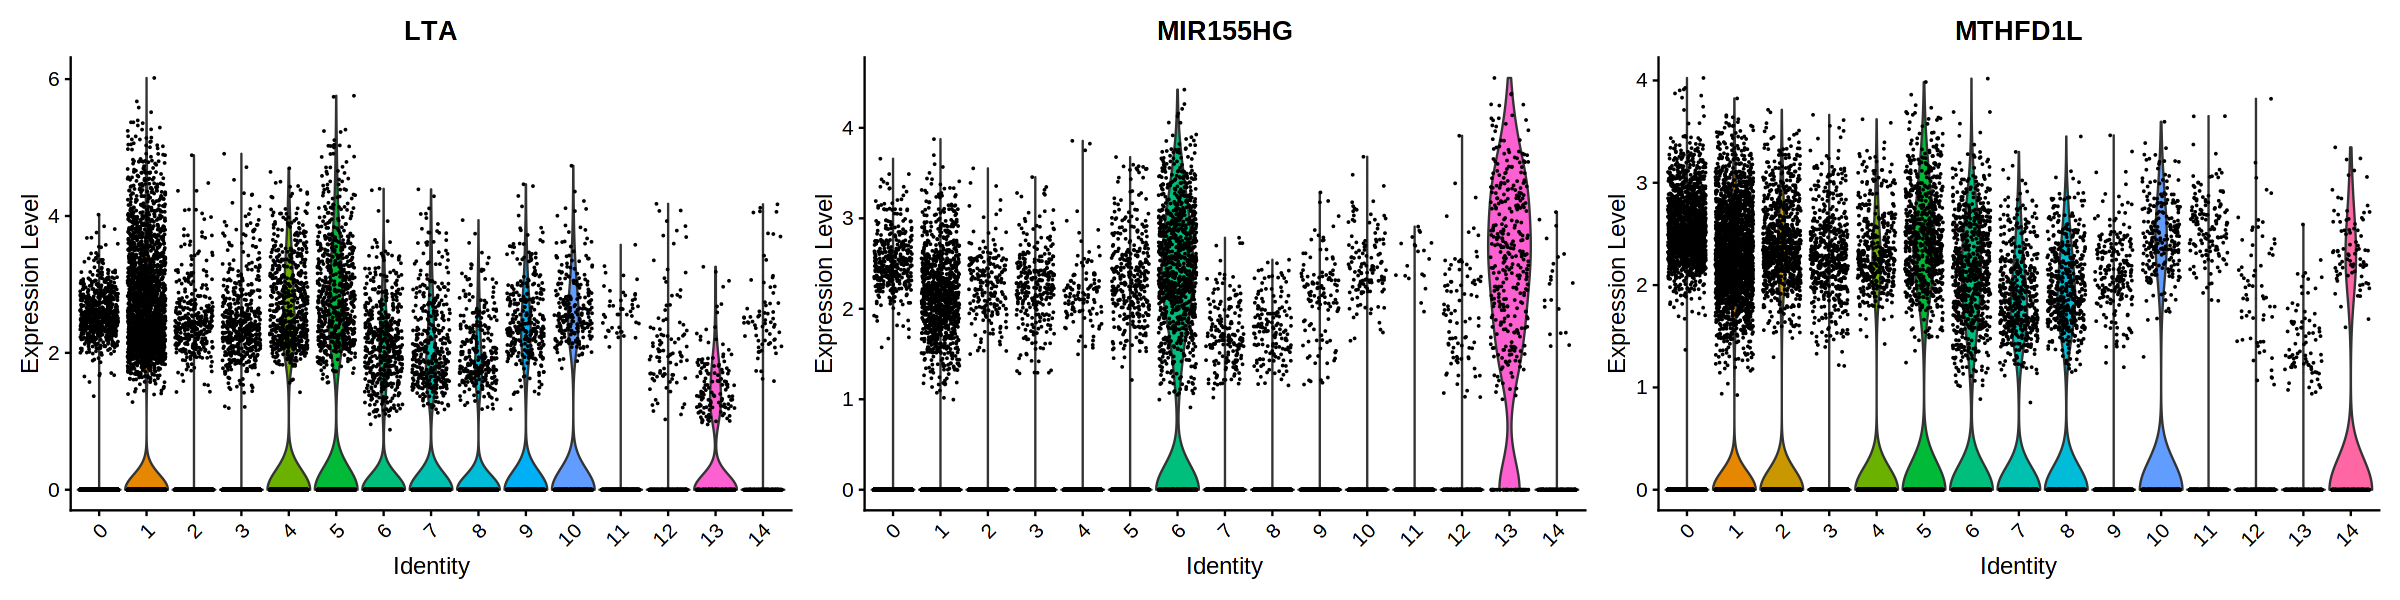

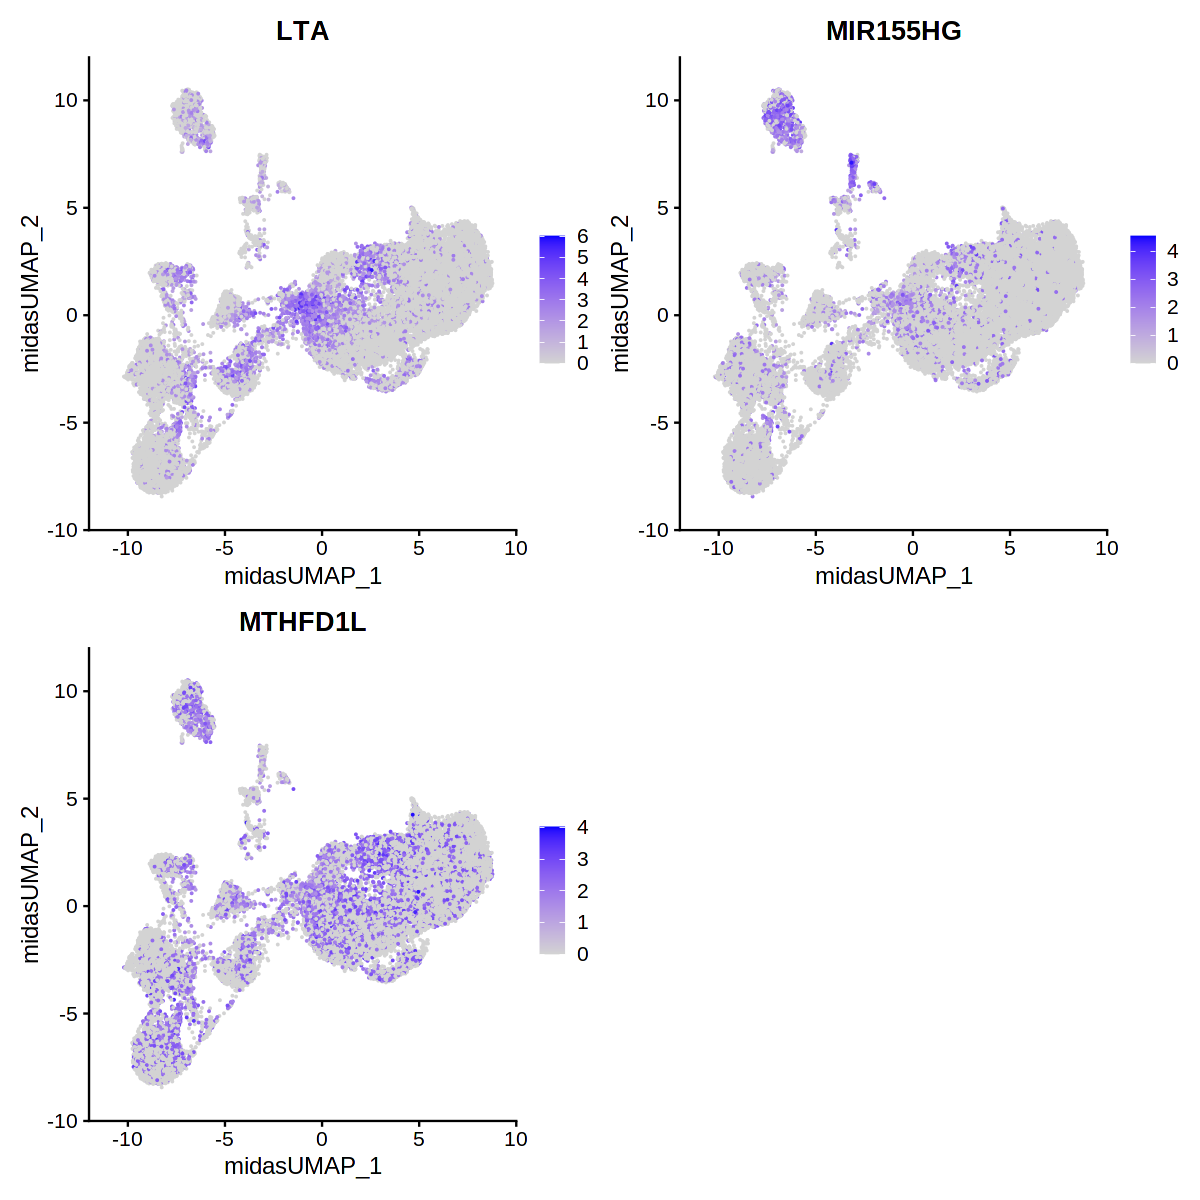

In [37]:
feats <- c("LTA", "MIR155HG", "MTHFD1L")

plt_size(w = 4*l, h = l)
VlnPlot(obj, features = feats, pt.size = 0.02)

plt_size(w = 2*l, h = 2*l)
FeaturePlot(obj, features = feats, reduction = "midas.umap")

### ADT DE

In [38]:
DefaultAssay(obj) <- "adt_bc"
markers_adt <- FindAllMarkers(obj, only.pos = T, min.pct = 0.25, logfc.threshold = 0.25)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14



In [39]:
markers_adt %>% group_by(cluster) %>%  slice_max(n = 3, order_by = avg_log2FC)

p_val         avg_log2FC pct.1 pct.2 p_val_adj     cluster gene     
1   0.000000e+00 0.4676178  1.000 0.857  0.000000e+00 0       cd4.2    
2   0.000000e+00 0.3941702  0.988 0.870  0.000000e+00 0       cd38.2   
3   0.000000e+00 0.3685909  1.000 0.988  0.000000e+00 0       cd307e   
4   0.000000e+00 0.4240020  0.999 0.948  0.000000e+00 1       cd29     
5   0.000000e+00 0.3881795  1.000 0.878  0.000000e+00 1       cd4.2    
6   0.000000e+00 0.3457452  0.936 0.852  0.000000e+00 1       cd49a    
7   0.000000e+00 0.9723649  1.000 0.996  0.000000e+00 2       cd8      
8   0.000000e+00 0.8773505  1.000 1.000  0.000000e+00 2       cd8a     
9   0.000000e+00 0.4631657  1.000 0.989  0.000000e+00 2       cd314    
10  0.000000e+00 0.9553372  1.000 0.996  0.000000e+00 3       cd8      
11  0.000000e+00 0.8611406  1.000 1.000  0.000000e+00 3       cd8a     
12  0.000000e+00 0.6647889  0.912 0.699  0.000000e+00 3       cd57     
13  0.000000e+00 1.0754918  0.996 0.534  0.000000e+00 4       cd161    
14  0.000000e+00 0.8362316  0.916 0.590  0.000000e+00 4       tcr.v.7.2
15  0.000000e+00 0.6956255  0.999 0.881  0.000000e+00 4       cd69     
16  0.000000e+00 0.8382359  0.997 0.881  0.000000e+00 5       cd69     
17  0.000000e+00 0.5447667  0.999 0.995  0.000000e+00 5       cd71     
18  0.000000e+00 1.7841608  1.000 0.903  0.000000e+00 6       cd72     
19  0.000000e+00 1.7430769  1.000 0.838  0.000000e+00 6       cd22     
20  0.000000e+00 1.4299723  0.999 0.780  0.000000e+00 6       cd21     
21 5.138984e-199 0.5909320  0.999 0.996 1.068909e-196 7       cd8      
22 1.351271e-223 0.5733616  1.000 1.000 2.810645e-221 7       cd8a     
23 4.441493e-263 0.3934758  1.000 0.990 9.238306e-261 7       cd314    
24  0.000000e+00 0.4448674  1.000 0.898  0.000000e+00 8       cd4.2    
25  0.000000e+00 0.3498532  1.000 0.991  0.000000e+00 8       cd307e   
26 9.614425e-297 0.3207295  1.000 0.972 1.999800e-294 8       cd209    
27  0.000000e+00 1.3065518  0.980 0.762  0.000000e+00 9       cd16     
28  0.000000e+00 1.1872209  1.000 0.854  0.000000e+00 9       cd56.2   
29  0.000000e+00 1.1855982  0.997 0.796  0.000000e+00 9       cd335    
30  0.000000e+00 0.8150177  1.000 0.996  0.000000e+00 10      cd25     
31 3.638513e-232 0.6602282  0.976 0.886 7.568107e-230 10      cd39     
32 1.475535e-162 0.4794389  0.895 0.716 3.069112e-160 10      cd137    
33  1.662931e-71 0.3252192  1.000 0.899  3.458896e-69 11      cd4.2    
34  1.058548e-70 0.2553683  1.000 0.991  2.201781e-68 11      cd307e   
35 6.577618e-303 1.4681063  1.000 0.695 1.368145e-300 12      clec12a  
36 2.421872e-292 1.3843500  1.000 0.751 5.037494e-290 12      cd11c    
37 1.982703e-277 1.3405544  1.000 0.742 4.124021e-275 12      cd141    
38 1.119245e-282 1.9592232  1.000 0.489 2.328029e-280 13      cd123    
39 8.769306e-215 1.6487936  0.992 0.743 1.824016e-212 13      cd141    
40 6.302287e-227 1.2863223  1.000 0.893 1.310876e-224 13      hla.dr   
41 3.100973e-141 0.6468122  1.000 0.990 6.450023e-139 14      cd314    
42  6.517368e-99 0.5049489  0.929 0.640  1.355613e-96 14      cd11b.2  
43  1.945266e-36 0.4763110  0.997 0.996  4.046153e-34 14      cd8

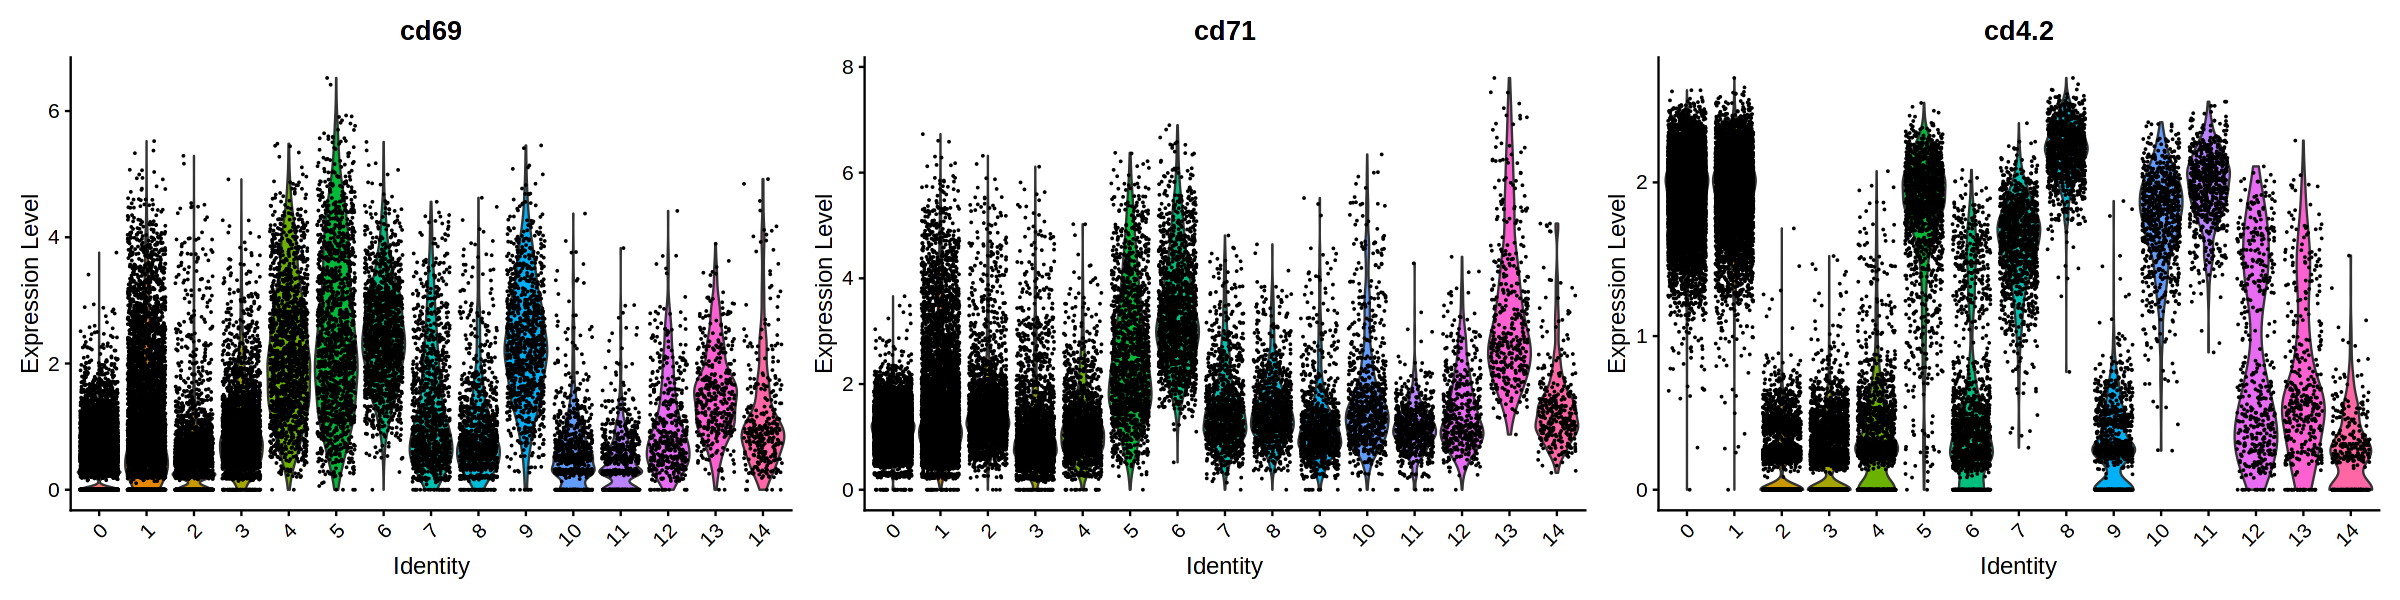

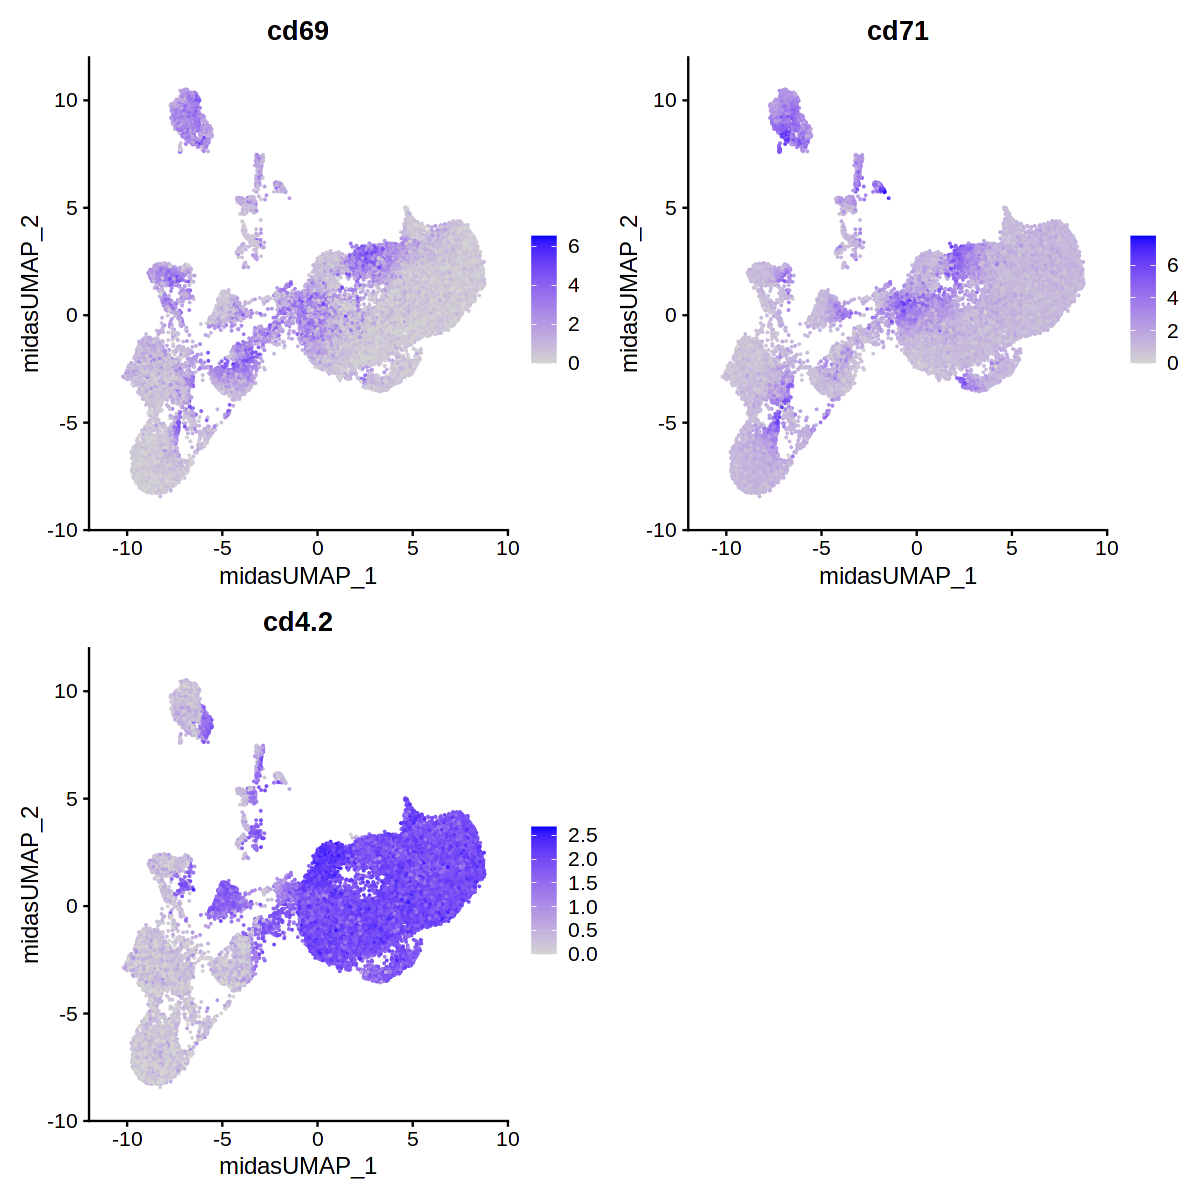

In [40]:
feats <- c("cd69", "cd71", "cd4.2")

plt_size(w = 4*l, h = l)
VlnPlot(obj, features = feats, pt.size = 0.02)

plt_size(w = 2*l, h = 2*l)
FeaturePlot(obj, features = feats, reduction = "midas.umap")

### ATAC DE

In [41]:
DefaultAssay(obj) <- "atac_bc"
markers_atac <- FindAllMarkers(obj, min.pct = 0.05, test.use = 'LR')

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Warning message in mccollect(jobs = jobs, wait = TRUE):
"1 parallel job did not deliver a result"
Calculating cluster 7

Warning message in mccollect(jobs = jobs, wait = TRUE):
"1 parallel job did not deliver a result"
Warning message in mccollect(jobs = jobs, wait = TRUE):
"1 parallel job did not deliver a result"
Warning message in mccollect(jobs = jobs, wait = TRUE):
"1 parallel job did not deliver a result"
Warning message in mccollect(jobs = jobs, wait = TRUE):
"1 parallel job did not deliver a result"
Warning message in mccollect(jobs = jobs, wait = TRUE):
"1 parallel job did not deliver a result"
Warning message in mccollect(jobs = jobs, wait = TRUE):
"1 parallel job did not deliver a result"
Warning message in mccollect(jobs = jobs, wait = TRUE):
"1 parallel job did not deliver a result"
Warning message in mccollect(job

In [42]:
markers_atac %>% group_by(cluster) %>%  slice_max(n = 3, order_by = avg_log2FC)

p_val         avg_log2FC pct.1 pct.2 p_val_adj     cluster
1  6.228443e-290 0.4595894  0.208 0.071 1.905219e-285 0      
2  1.790771e-296 0.4540876  0.253 0.100 5.477790e-292 0      
3   0.000000e+00 0.4330810  0.379 0.190  0.000000e+00 0      
4  3.099591e-309 0.5607153  0.208 0.051 9.481338e-305 1      
5  5.696894e-262 0.5025275  0.250 0.087 1.742623e-257 1      
6  5.727918e-283 0.4841981  0.362 0.160 1.752113e-278 1      
7   0.000000e+00 0.8621687  0.287 0.038  0.000000e+00 2      
8  3.214144e-319 0.7507891  0.183 0.016 9.831745e-315 2      
9  6.008307e-286 0.7173633  0.290 0.063 1.837881e-281 2      
10  0.000000e+00 0.9438147  0.401 0.068  0.000000e+00 3      
11  0.000000e+00 0.8480994  0.560 0.156  0.000000e+00 3      
12  0.000000e+00 0.8190078  0.301 0.052  0.000000e+00 3      
13  0.000000e+00 1.0858250  0.310 0.021  0.000000e+00 4      
14 3.674035e-309 1.0146913  0.345 0.040 1.123851e-304 4      
15 3.443456e-299 1.0013874  0.296 0.027 1.053319e-294 4      
16  5.509835e-34 0.3472268  0.154 0.062  1.685403e-29 5      
17  1.813992e-33 0.3367964  0.097 0.028  5.548821e-29 5      
18  4.915386e-43 0.3356875  0.054 0.006  1.503568e-38 5      
19  1.105881e-40 0.4395750  0.198 0.057  3.382780e-36 7      
20  2.227735e-49 0.4292471  0.439 0.181  6.814419e-45 7      
21  1.177022e-38 0.4188805  0.252 0.090  3.600394e-34 7      
22  2.182637e-45 0.4563223  0.327 0.119  6.676469e-41 8      
23  1.931541e-40 0.4460118  0.254 0.085  5.908391e-36 8      
24  1.819895e-32 0.4057432  0.172 0.052  5.566876e-28 8      
25  0.000000e+00 1.2899703  0.368 0.018  0.000000e+00 9      
26 6.469955e-245 1.1288069  0.296 0.016 1.979094e-240 9      
27 9.215723e-236 1.1038454  0.395 0.044 2.818998e-231 9      
28  7.920255e-92 0.7822020  0.219 0.032  2.422727e-87 10     
29  8.302975e-89 0.7776312  0.277 0.054  2.539797e-84 10     
30  1.586983e-78 0.7354363  0.191 0.027  4.854423e-74 10     
31  5.492869e-47 0.8872149  0.299 0.045  1.680214e-42 14     
32  1.060799e-32 0.7366237  0.241 0.044  3.244879e-28 14     
33  3.150722e-21 0.5887084  0.196 0.044  9.637744e-17 14     
   gene                     
1  chr4-108355218-108356542 
2  chr2-172495635-172497012 
3  chr20-44068494-44070701  
4  chr5-912073-913040       
5  chr19-39430192-39431463  
6  chr1-159076373-159077829 
7  chr12-10554091-10555361  
8  chr11-3006488-3007260    
9  chr1-8926608-8927899     
10 chr2-86785396-86786586   
11 chr17-3794866-3797096    
12 chr12-22409188-22410722  
13 chr11-114065829-114066954
14 chr16-81524213-81524739  
15 chr2-227817824-227819038 
16 chr1-101178288-101179703 
17 chr21-45818371-45819313  
18 chr2-190721900-190723258 
19 chr12-10554091-10555361  
20 chr17-3794866-3797096    
21 chr17-83083352-83084155  
22 chr11-129853281-129854521
23 chr1-234408461-234409648 
24 chr2-1509089-1510078     
25 chr1-36400619-36401599   
26 chr3-5037761-5038582     
27 chr17-36066232-36067184  
28 chr11-76629197-76630521  
29 chr10-6072190-6073051    
30 chr11-76587878-76589384  
31 chr14-105858791-105860252
32 chr14-105857213-105858645
33 chr17-35890439-35891122

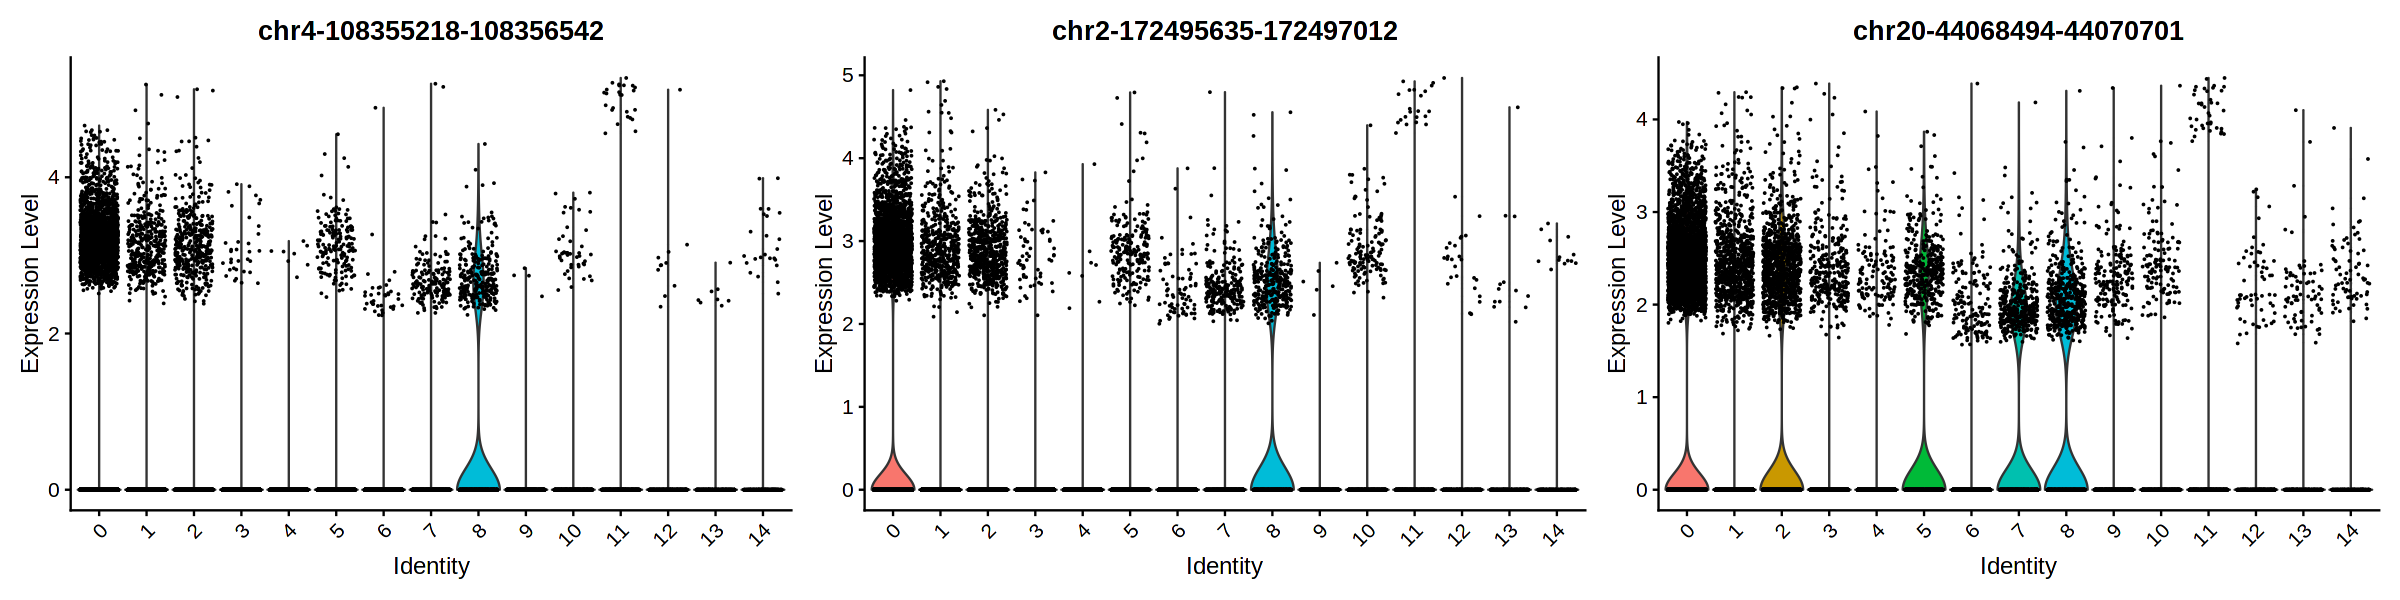

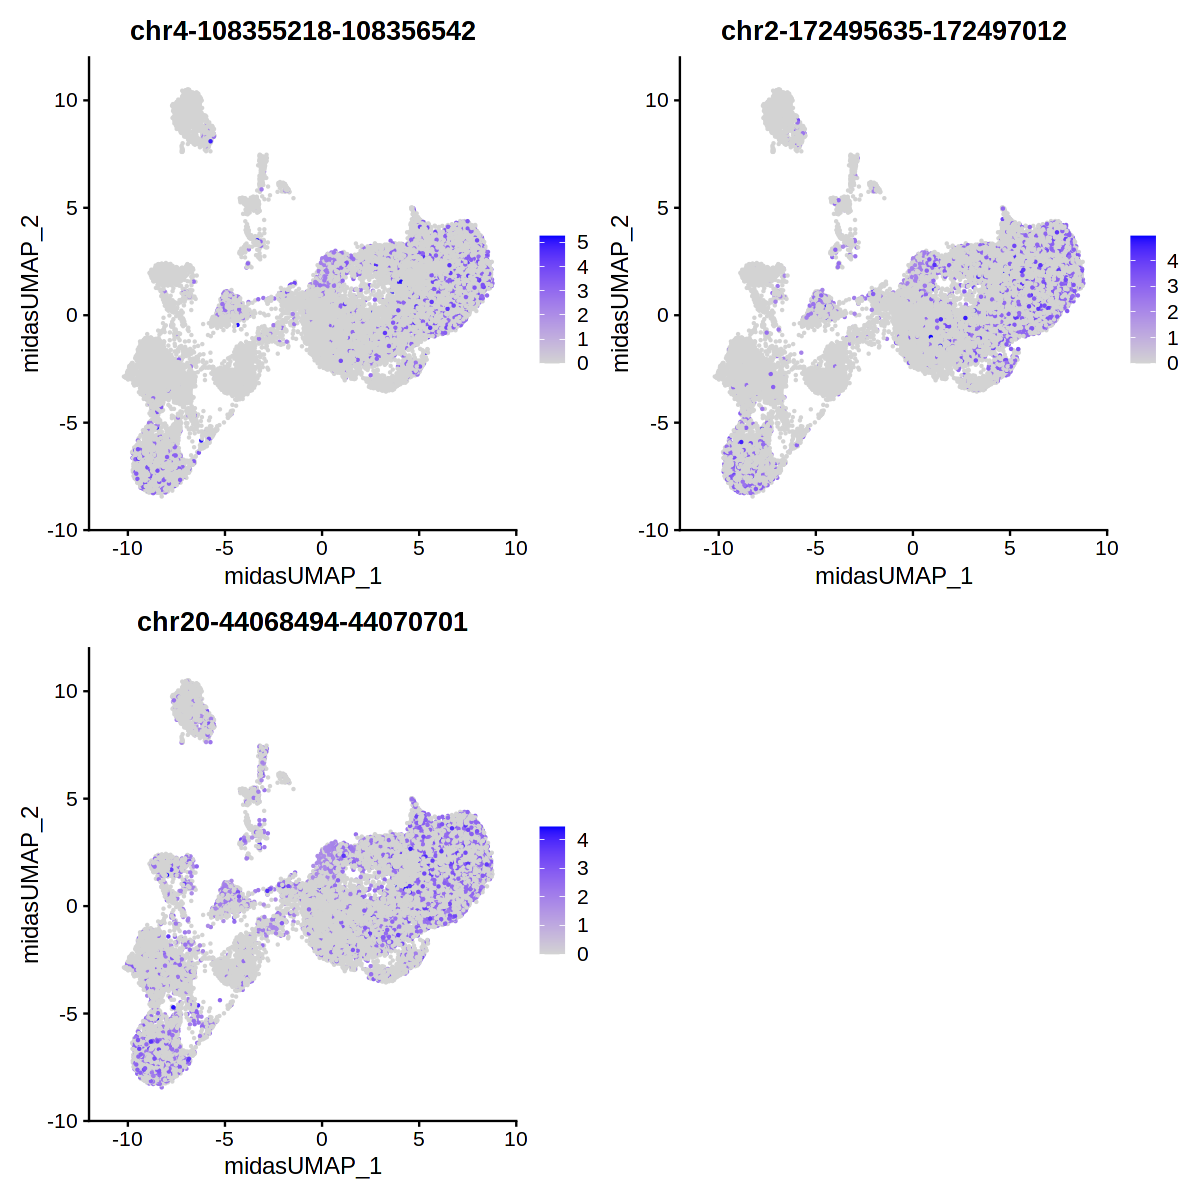

In [43]:
feats <- c("chr4-108355218-108356542", "chr2-172495635-172497012", "chr20-44068494-44070701")

plt_size(w = 4*l, h = l)
VlnPlot(obj, features = feats, pt.size = 0.02)

plt_size(w = 2*l, h = 2*l)
FeaturePlot(obj, features = feats, reduction = "midas.umap", min.cutoff = 0, pt.size = 0.2)

In [44]:
ClosestFeature(obj, regions = feats)

tx_id           gene_name gene_id         gene_biotype        
ENSE00002056730 ENST00000512129 LEF1-AS1  ENSG00000232021 processed_transcript
ENST00000475302 ENST00000475302 ITGA6     ENSG00000091409 protein_coding      
ENST00000423191 ENST00000423191 TOX2      ENSG00000124191 protein_coding      
                type closest_region           query_region             distance
ENSE00002056730 exon chr4-108256645-108256836 chr4-108355218-108356542 98381   
ENST00000475302 gap  chr2-172491524-172497974 chr2-172495635-172497012     0   
ENST00000423191 cds  chr20-44068650-44068686  chr20-44068494-44070701      0

In [45]:
# convert the notebook to html
system(paste0("jupyter nbconvert --to html analysis/downstream.ipynb"))